In [1]:
import requests
from lxml import etree

def get_play_count(url, title):
    headers = {'user-agent': 'Mozilla/5.0'}
    res = requests.get(url, headers=headers)
    html = etree.HTML(res.text)
    play_count = html.xpath("//span[@class='play-count']/text()")[0]
    return {title: int(play_count)}

def get_main():
    url = 'https://space.bilibili.com/3461563583302074/channel/seriesdetail?sid=2704247' 
    total_count = {}
    
    for page in range(1, 31):
        play_url = f'{url}?p={page}'
        title = f'Page {page}' 
        play_count = get_play_count(play_url, title)
        total_count.update(play_count)
        
    print(total_count)


In [55]:
import pandas as pd
import numpy as np
import subprocess
import os,re,random,time

In [139]:
##! 直接使用api获取
## https://api.bilibili.com/x/series/archives?mid=3461563583302074&series_id=2704247&only_normal=true&sort=desc&ps=1000
import json , re
from datetime import datetime

#! load json 时使用 itemect_hook进行预处理
def deserialize(item):
  # if 'pubdate' in item: # 一定有的话可不加if, 遍历内层的item也需先遍历外层 {'a':[{'title':'11'..},{}....]}
    
    if 'title' in item:
        # print(obj) 
        # print('111',item['stat'] )
        item['pubdate'] = datetime.fromtimestamp(int(item['pubdate']))
        item['stat'] = item['stat']['view'] 
        singer = re.findall('【(.*?)】',item['title'])
        item['singer'] =re.sub('[翻跳唱|丨精译]','',singer[-1])  if singer else ''
        song = re.findall('《(.*?)》',item['title'])
        song = song if song else re.findall('『(.*?)』',item['title'])
        item['song'] = song[0] if song else ''
    return item
# data = json.load(f, itemect_hook=deserialize)

In [140]:
with open('bili_list_data.json') as f:
    data_list = json.load(f,object_hook=deserialize) 

In [149]:
df = pd.DataFrame(data_list['archives']) 

url_prefix = 'https://www.bilibili.com/video/'
df['bvid'] = df['bvid'].apply(lambda x: '=HYPERLINK("{}", "{}")'.format(url_prefix +x, x ))
#  =HYPERLINK("{}", "{}"    ="<table><img src="&C2&" height=66 width=106></table>" 
writer = pd.ExcelWriter('output.xlsx')
df.to_excel(writer, index=False) 
writer.save()

C:\Users\ricar\AppData\Local\Temp\ipykernel_1184\932080961.py:8: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


In [43]:
df = pd.read_excel('EOE歌曲列表.xlsx') 

In [53]:
df['演唱'].unique()

array(['虞莫', '莞儿', '米诺', '柚恩', '露早', '露早&柚恩', '莞儿2D', '露早&虞莫', '莞儿&柚恩',
       '米诺2D', '虞莫&柚恩', '虞莫&米诺', '露早＆虞莫', '莞儿虞莫', '合唱', '米诺&柚恩', '露早&莞儿',
       '莞儿&米诺', '露早2D', '虞莫2D', '露早&虞莫&米诺', '露早&米诺', '柚恩电台', '莞儿&米诺&柚恩',
       '虞莫&莞儿', '露早电台', '莞儿电台', '露早&莞儿&柚恩'], dtype=object)

In [46]:
df['演唱'] = df['演唱'].apply(lambda x : '&'.join(sorted(x.split('&'),reverse=True)) )

In [52]:
df.to_excel('testout.xlsx' )

In [54]:
for folder in df['演唱'].unique():
    if not os.path.exists(folder): 
        os.makedirs(folder)

In [ ]:
delay =5 + random.uniform(-1, 2)
count = 1
start = 826
limit = 1111 
for index,row in df.iterrows():
    if count<start :
        count+=1
    else:
        workdir = row['演唱'] 
        title = row['标题']
        bv = row['bv链接']
        ind = row['序号']
        is2d = re.search('2(d|D)|(电台)',title)
        title ='' if is2d else f"-M {ind}"
        is2d  ='' if is2d else '-p 1'
        comd = f"BBDown {bv} --audio-only -hs {is2d} --work-dir {workdir}  {title}"  #  --skip-cover 
        process = subprocess.Popen(comd, shell=False, stdout=subprocess.PIPE, stderr=subprocess.PIPE )
        #如果使用 shell=True,则需要在命令字符串中处理引号。
        #而 shell=False 时,可以直接在 参数列表 中使用引号表示字符串参数
        out, err = process.communicate()
        out = out.decode('gbk')
        err = err.decode('gbk')
        err = '\n'+err if err else ''  
        print(f'{comd}\ncount:{count} out:{out[-30:]}{err}') 
        if err or re.search('([e|E]rror)|(command)',out) or (count>limit):  
            break
        count +=1
        time.sleep(delay)

In [ ]:
music_dir = r'F:\AI_Doc\dataset-tools\test\00测试'
# import eyed3
for root, dirs, files in os.walk(music_dir):
    for file in files:
        if file.endswith('.m4a'):
            path = os.path.join(root, file)
            
            # 提取文件名的数字
            name = os.path.splitext(file)[0]
            # 删除所有[]
            if '[]' in name:
                new_path = os.path.join(root, name.replace('[]','')+'.m4a')
                os.rename(path, new_path)
            if name.isdigit():
                index = int(name) 
                # 根据序号在表格中查找对应标题  
                if index-1 < len(df['标题']):
                    new_title = df['标题'][index-1]
                    new_name = f'{new_title}.m4a'
                    # win文件名不能包含以下字符
                    new_name = re.sub('[\/:?*"<>|]',' ',new_name)
                    if index in df['歌曲'].values:
                        print(index,'可能冲突')
                        # 还有标题也可能重名 暂未考虑 ，添加日期后缀解决
                    else:# 重命名文件
                        new_path = os.path.join(root, new_name)
                        os.rename(path, rf'{new_path}')
                    # 修改mp3标签中的标题
                    # audiofile = eyed3.load(path)
                    # audiofile.tag.title = new_title
                    # audiofile.tag.save()

                    print(f'{file} --> {new_title}')

In [166]:
testdf = df[df['标题']=='『甜甜的』“我喜欢的样子你都有”【莞儿翻唱】'][['序号','时间']]
testdf['时间2'] =testdf['时间'].dt.strftime('%y.%m.%d')+'_'+testdf['序号'].astype(str) #转为str才能拼接
testdf

In [182]:
testdf['时间2'].values[0]

序号                  时间         时间2
3   4 2023-09-03 22:35:49  23.09.03_4

In [198]:
music_dir = r'F:\AI_Doc\dataset-tools\test\00测试'
# import eyed3
df['test'] = df['标题'].apply(lambda x : re.sub('[\/:?*"<>|]',' ',x) )
for root, dirs, files in os.walk(music_dir):
    for file in files:
        if file.endswith('.m4a'):
            path = os.path.join(root, file)
            
            # 提取文件名的数字
            name = os.path.splitext(file)[0]
            #new_name = re.sub('[\/:?*"<>|]',' ',new_name)

            if name in df['test'].values:
                testdf = df[df['test']==name][['序号','时间']]
                if len(testdf)>1:
                    print(testdf)
                else:
                    testdf['时间2'] =testdf['时间'].dt.strftime('%y.%m.%d')+'_'+testdf['序号'].astype(str) #转为str才能拼接
                    new_path = os.path.join(root, name+testdf['时间2'].values[0]+'.m4a')
                    os.rename(path, new_path)
              # print(f'{file} --> {new_title}')

      序号                  时间
64    65 2023-08-13 22:47:02
363  364 2023-04-08 22:17:03
      序号                  时间
358  359 2023-04-09 21:14:50
647  648 2022-12-27 22:54:33


In [10]:

# 运行命令
# subprocess.run(["cmd", "/c", "dir C:\\"], shell=True)

# 运行命令并获取输出    #  -p 1    --multi-file-pattern '<videoTitle>'
comd = "BBDown BV1Hu411P7Vw --audio-only -hs {is2d} --work-dir {workdir} {title}"
result = subprocess.run(comd, shell=True, stdout=subprocess.PIPE)
print(result.stdout.decode(errors='ignore') )

#BBDown BV1Hu411P7Vw --audio-only -hs -p 1

### ffmpeg -i 女孩与王冠_0.4.wav -c:a libmp3lame -qscale:a 2 -c:a aac -b:a 320k -ar 48000 -ac 2 output.m4a
ffmpeg -i 女孩与王冠_0.4.wav -ss 00:00:00 -t 00:01:49 -c:a aac -b:a 320k output.m4a 
# 转成mp4再改名m4a 才行
ffmpeg -i 女孩与王冠_0.4.wav -c:a libmp3lame -qscale:a 2 -c:a aac -b:a 320k -ar 48000 -ac 2 output.m4a

In [136]:
"""re.findall('【.*?】',' [【孤独万岁】『失恋无罪』A-Lin【虞莫翻唱】')[-1]
re.findall('『(.+?)』|《(.+)》',' 《步步惊心》片尾曲『三寸天堂』“')"""

[('', '步步惊心'), ('三寸天堂', '')]

In [ ]:
import requests
import json

In [ ]:
song_name = '一路向北' # 替换为要查询的歌名

 # http://openapi.music.163.com/openapi/music/basic/search/song/by/artist/song/get/v2/songName=%E4%B8%83%E9%87%8C%E9%A6%99
# https://zj.v.api.aa1.cn/api/qqmusic/?songName=稻香&singerName=周杰伦&pageNum=1&pageSize=5&type=qq	    	歌曲名  singerName, playlistId, pageNum, pageSize, type 

url = f'https://zj.v.api.aa1.cn/api/qqmusic/?songName={song_name}&pageNum=1&pageSize=5&type=qq'
response = requests.get(url)
data = json.loads(response.text)
 
print(data)
print([i.singer for i in data['list']])

In [36]:
import os
import mutagen

# 指定父文件夹
parent_folder = r'EOE歌曲/2D' 

result = {}

def getm4a_info(dir_path):
    if os.path.isfile(dir_path):
        audio = mutagen.File(dir_path)  
        if audio:
            if '©nam' in audio:
                title = audio['©nam'][0]
            else:
                title = 'Unknown Title'
        else:
            title = 'Unknown Title'
        return title
    
    title_list = []
    print(os.path.basename(dir_path))  
    for file in os.listdir(dir_path): 
        if file.endswith('.m4a'):
            file_path = os.path.join(dir_path, file) 
            audio = mutagen.File(file_path)  
            if audio:
                if '©nam' in audio:
                    title = audio['©nam'][0]
                else:
                    title = 'Unknown Title'
            else:
                title = 'Unknown Title'
        title_list.append(title)
    return title_list

# 遍历所有子文件夹
for dir in os.listdir(parent_folder):
    dir_path = os.path.join(parent_folder, dir)
    if os.path.isdir(dir_path):
        titles = []
        
        # 遍历子文件夹中的音频文件
        for file in os.listdir(dir_path): 
             
            print('|'.join(getm4a_info(os.path.join(dir_path, file))))

        # 添加到结果字典中    
        #result[dir] = titles
        
# print(result)

『腐草为萤』『secret base ~君がくれたもの~』原唱版【柚恩电台翻唱】
腐草为萤|secret base ~君がくれたもの~|半首『罪恶王冠』Departures ～あなたにおくるアイの歌～
【柚恩电台翻唱】02.12柚恩电台歌切合集
被风吹过的夏天|心上秋|A Tiny Winter Story|春よ、来い|我就是这种女孩|多情岸|乘风|再见深海
【柚恩电台翻唱】04.18柚恩电台歌切合集
红色高跟鞋(电台）|牵丝戏|如见青山|如愿|无语|遗失的美好|寓言|自由的飞翔
【米诺2D翻唱】07.29米诺2D歌切合集
2023.07.29 米诺 带我去找夜生活|2023.07.29 米诺 温蒂公主的侍卫|2023.07.29 米诺 爱人错过
合|集|【|弹|幕|】
【莞儿2D翻唱】08.12莞儿2D歌切合集
2023.08.11 莞儿 蠢货|2023.08.11 莞儿 下雨天|2023.08.11 莞儿 爱的魔力转圈圈
【莞儿电台翻唱】01.26莞儿电台歌切合集
反方向的钟|写给我第一个喜欢的女孩的歌|给我一首歌的时间|蠢货|夜空中最亮的星|追光者|secret base 你给我的所有~|爱如火|小幸运|勾指起誓|野狼disco|迷迭香|手写的从前|樱花的告白|A little love
【虞莫2D翻唱】05.03虞莫2D歌切合集
【字幕版】倒带|【字幕版】一眼万年|【字幕版】我爱他|【字幕版】雨爱|【字幕版】你是我的风景|❤❤❤❤❤
【露早2D翻唱】05.09露早2D歌切合集
Love Fool|LOVE|水星记|fly me to the moon|黒い涙|夏天的风
【露早电台翻唱】01.12露早电台歌切合集
Forever|I'm your girl|Reflection|Summer time gone|Sweets parade|Sweets parade小早版|Time after time|Would U|氷の上に立つように|匆匆那年|恋に恋して|夢にエール！パティシエール♪小早版|水星记|童话|偷偷|夏天的风|星空☆ディスティネーション|永不失联的爱
【露早电台翻唱】02.03露早电台歌切合集
Fly Me To the Moon|close to you|...|Ditto|Honey|Hype Boy|特别的人|有你的快乐
【露早电台翻唱】

In [20]:
file_path = r'F:\AI_Doc\dataset-tools\test\EOE歌曲\2D\莞儿2D\【莞儿2D翻唱】08.12莞儿2D歌切合集\[P1]2023.08.11 莞儿 蠢货.m4a' 
audio = mutagen.File(file_path)

if audio:
    if '©nam' in audio:
        title = audio['©nam'][0]
    else:
        title = 'Unknown Title'
else:
    title = 'Unknown Title'
    
title

'2023.08.11 莞儿 蠢货'

22/22 [==============================] - 4s 195ms/step


Text(0, 0.5, 'Fundamental frequency (Hz)')

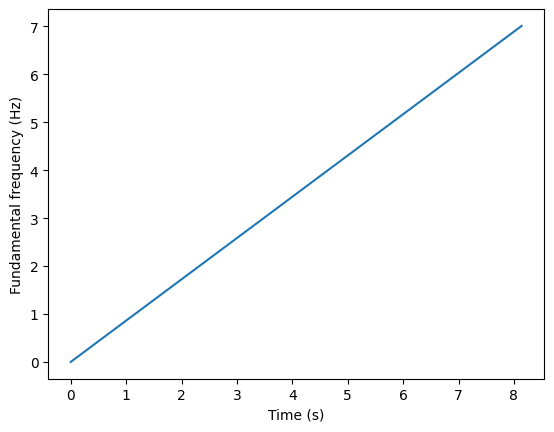

In [6]:
import crepe
import numpy as np
import pathlib,librosa
import matplotlib.pyplot as plt

audio_file = pathlib.Path('花海-小暗_zaozao.wav')
audio, sr = librosa.load(audio_file) 

hop_length = 256
f0, voiced_prob, voiced_flags,_ = crepe.predict(audio, sr,) #  hop_length=hop_length, model_capacity='full'

times = librosa.frames_to_time(np.arange(len(f0)), sr=sr, hop_length=hop_length)

plt.plot(times, f0)
plt.xlabel('Time (s)')
plt.ylabel('Fundamental frequency (Hz)')

In [ ]:

pip install git+https://github.com/YannickJadoul/Parselmouth 

In [17]:
from parselmouth.praat import read, run_file

sound =  read(audio_file) #   call(audio_file, "Read from file", 0, 0)
pitch = call(sound, "To Pitch", 0.0, 75, 600) 
pitch = run_file("pitch_extract.praat", audio_file) 
plt.plot(pitch.values.T[0], pitch.values.T[1])
plt.xlabel('Time (s)')
plt.ylabel('Fundamental frequency (Hz)')

ImportError: cannot import name 'read' from 'parselmouth.praat' (unknown location)